In [11]:
import os
import sys
import scipy.stats

import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import function

from importlib import reload
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import classification_report  
from sklearn.linear_model import LogisticRegression
from scipy.signal import butter, filtfilt
from scipy.signal import detrend
from scipy.signal import find_peaks

plt.style.use('ggplot')

In [12]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot
from function import *

In [14]:
#main_dir =  r"C:\Users\user\Desktop\EPFL\MA1\projet_cellular\neuro_circuit"
main_dir = r"C:/Users/maxca/Documents/EPFL/Computational_neuro/Project/neuro_circuit"

fname = '/data_bio482.pkl'
data_df = pd.read_pickle(main_dir + fname)

In [15]:
# Select the relevant columns from data_df and assign them to cells_df
cells_df = data_df[['Cell_ID', 'Cell_Type', 'Cell_APThreshold_Slope', 'Cell_Depth', 'Cell_Layer', 'Cell_TargetedBrainArea', 'Sweep_MembranePotential']]
sampling_rate = 20000

In [16]:
cell = 17
noisy_cell = 5

# Extracting data for a specific cell from the DataFrame
Vm = cells_df['Sweep_MembranePotential'].iloc[cell]  # Get membrane potential for the cell at index 'cell'
#deriv_thresh = cells_df['Cell_APThreshold_Slope'].iloc[cell]  # Get action potential threshold slope for the same cell

# Extracting similar data for another cell, referred to as 'noisy_cell'
Vm2 = cells_df['Sweep_MembranePotential'].iloc[noisy_cell]  # Get membrane potential for the cell at index 'noisy_cell'
#deriv_thresh2 = cells_df['Cell_APThreshold_Slope'].iloc[noisy_cell]  # Get action potential threshold slope for 'noisy_cell'

In [17]:
reload(function)

<module 'function' from 'c:\\Users\\maxca\\Documents\\EPFL\\Computational_neuro\\Project\\neuro_circuit\\function.py'>

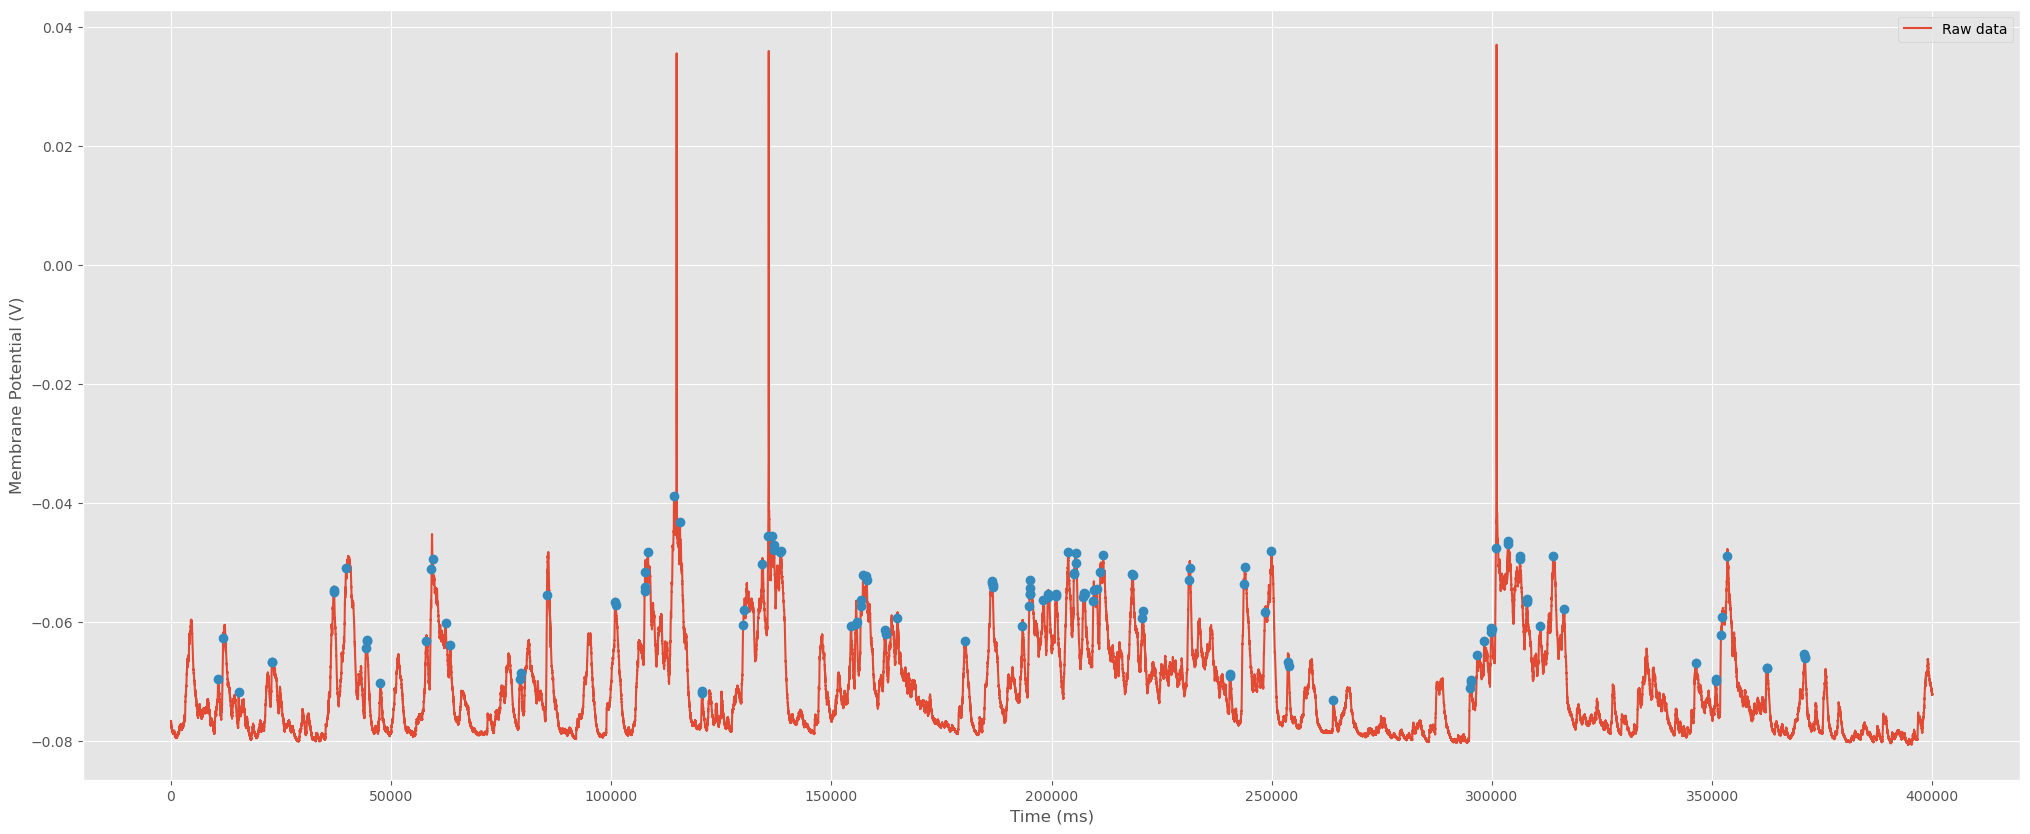

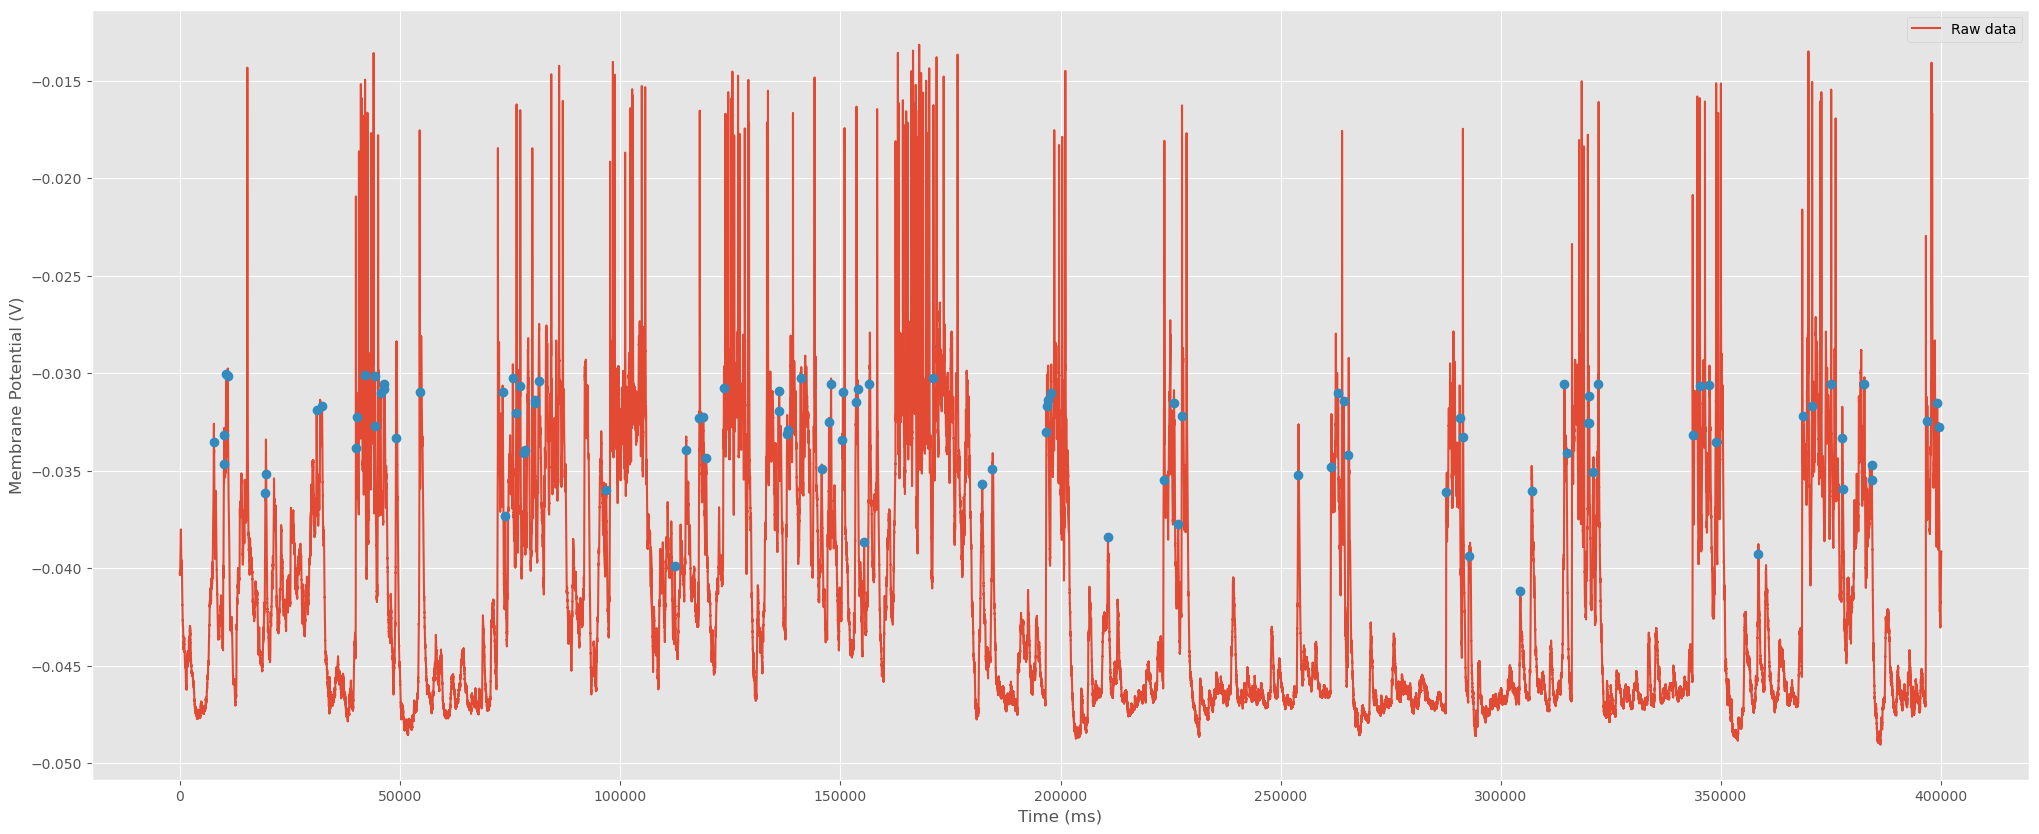

In [18]:
reload(function)
lower_threshold = lower_bound(Vm, mvg_avg_window = 2000, sub_window_size=20000)
upper_threshold = 0.004
window_size = 900

spikelet_params, spikelet_indices = find_spikelet_moving_avg(Vm, window_size=window_size, lower_threshold=lower_threshold, SR_Vm=sampling_rate)
spikelet_testplot(Vm, spikelet_indices) 

spikelet_params2, spikelet_indices2 = find_spikelet_moving_avg(Vm2, window_size=window_size, lower_threshold=lower_threshold, SR_Vm=sampling_rate)
spikelet_testplot(Vm2, spikelet_indices2)

In [19]:
reload(function)

spikelet_params3, spikelet_indices3=find_spikelet_moving_avg(data_df['Sweep_MembranePotential'].iloc[5], sampling_rate, 10)
display(cells_df.head(1), df_spikelet_converter(spikelet_params3))


,Cell_ID,Cell_Type,Cell_APThreshold_Slope,Cell_Depth,Cell_Layer,Cell_TargetedBrainArea,Sweep_MembranePotential
0,SC901_1,EXC,10.0,229.0,L2/3,C2,"[-0.044009375, -0.044028125, -0.0439875, -0.04..."


,spikelet_thresh_times,spikelet_thresh_vm,spikelet_peak_times,spikelet_peak_vm,spikelet_amp
0,0.76610,-0.022400,0.76620,-0.015809,0.006591
1,1.99895,-0.028581,1.99900,-0.024728,0.003853
2,2.03355,-0.023688,2.03360,-0.020837,0.002850
3,2.05530,-0.023044,2.05540,-0.016791,0.006253
4,2.06475,-0.023484,2.06485,-0.017375,0.006109
...,...,...,...,...,...
98,18.75045,-0.020481,18.75050,-0.017678,0.002803
99,18.80120,-0.022550,18.80125,-0.019550,0.003000
100,19.82610,-0.030553,19.82620,-0.024481,0.006072
101,19.89020,-0.018241,19.89025,-0.015800,0.002441


In [20]:
reload(function)
spikelet_summary_df = cells_df.apply(calculate_spikelet_params, axis=1)

In [23]:
display(spikelet_summary_df.describe(), spikelet_summary_df.head(1))


,nbr_spikelets,avg_spikelet_duration,avg_spikelet_amp,avg_spikelet_thresh_vm,avg_consecutive_spikelet_interval
count,831.000000,831.000000,831.000000,831.000000,831.000000
mean,1576.805054,0.000326,0.000167,-0.050644,0.536166
std,1384.294237,0.000092,0.000235,0.006107,1.275417
min,19.000000,0.000056,0.000005,-0.068118,0.051087
25%,579.500000,0.000265,0.000044,-0.054392,0.189266
50%,1235.000000,0.000320,0.000081,-0.050479,0.311517
75%,2026.500000,0.000389,0.000194,-0.046534,0.452276
max,11741.000000,0.000493,0.002723,-0.031528,25.001842


,nbr_spikelets,avg_spikelet_duration,avg_spikelet_amp,avg_spikelet_thresh_vm,avg_consecutive_spikelet_interval
0,246.0,0.000372,0.000097,-0.037037,0.806739


In [22]:
spikelet_summary_df.to_csv('spikelet.csv', index=False)

In [29]:
#we want to combine the spikelet data with the cell data
merged_df = data_df.merge(spikelet_summary_df, left_index=True, right_index=True)
display(merged_df.head(5))

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes,nbr_spikelets,avg_spikelet_duration,avg_spikelet_amp,avg_spikelet_thresh_vm,avg_consecutive_spikelet_interval
0,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]",246.0,0.000372,0.000097,-0.037037,0.806739
1,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006...",314.0,0.000389,0.000133,-0.037274,0.598717
2,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,2005.0,passive contact,"[1.4958937492820894, 1.5019819900587095, 1.509...",100.0,"[[2.15, 3.652], [4.362, 5.848]]",276.0,0.000420,0.000211,-0.034660,0.715058
3,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,2005.0,active touch,"[2.467493802679826, 2.459711310964792, 2.46562...",100.0,"[[2.766, 12.026], [15.626, 18.406], [18.814, 1...",501.0,0.000430,0.000387,-0.032777,0.398082
4,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,2005.0,active touch,"[2.4399999999999977, 2.4399999999999977, 2.440...",100.0,"[[5.228, 5.624], [7.462, 8.022], [11.002, 15.2...",462.0,0.000374,0.000161,-0.034555,0.406127


In [32]:
display(merged_df.Sweep_Type.unique())

active_touch_df = merged_df[merged_df['Sweep_Type']=='active touch']
passive_touch_df = merged_df[merged_df['Sweep_Type']=='passive touch']
whisking_df = merged_df[merged_df['Sweep_Type']=='free whisking']

array(['active touch', 'passive contact', 'free whisking'], dtype=object)

C:\Users\maxca\AppData\Local\Temp\ipykernel_50748\67825049.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=x, y=y, data=df, color=".25", jitter=True, ax=ax, palette=palette)
C:\Users\maxca\AppData\Local\Temp\ipykernel_50748\67825049.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(x=x, y=y, data=df, capsize=.2, ax=ax, palette=palette)
C:\Users\maxca\AppData\Local\Temp\ipykernel_50748\67825049.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=x, y=y, data=df, color=".25", jitter=True, ax=ax, palette=palette)
C:\Users\maxca\

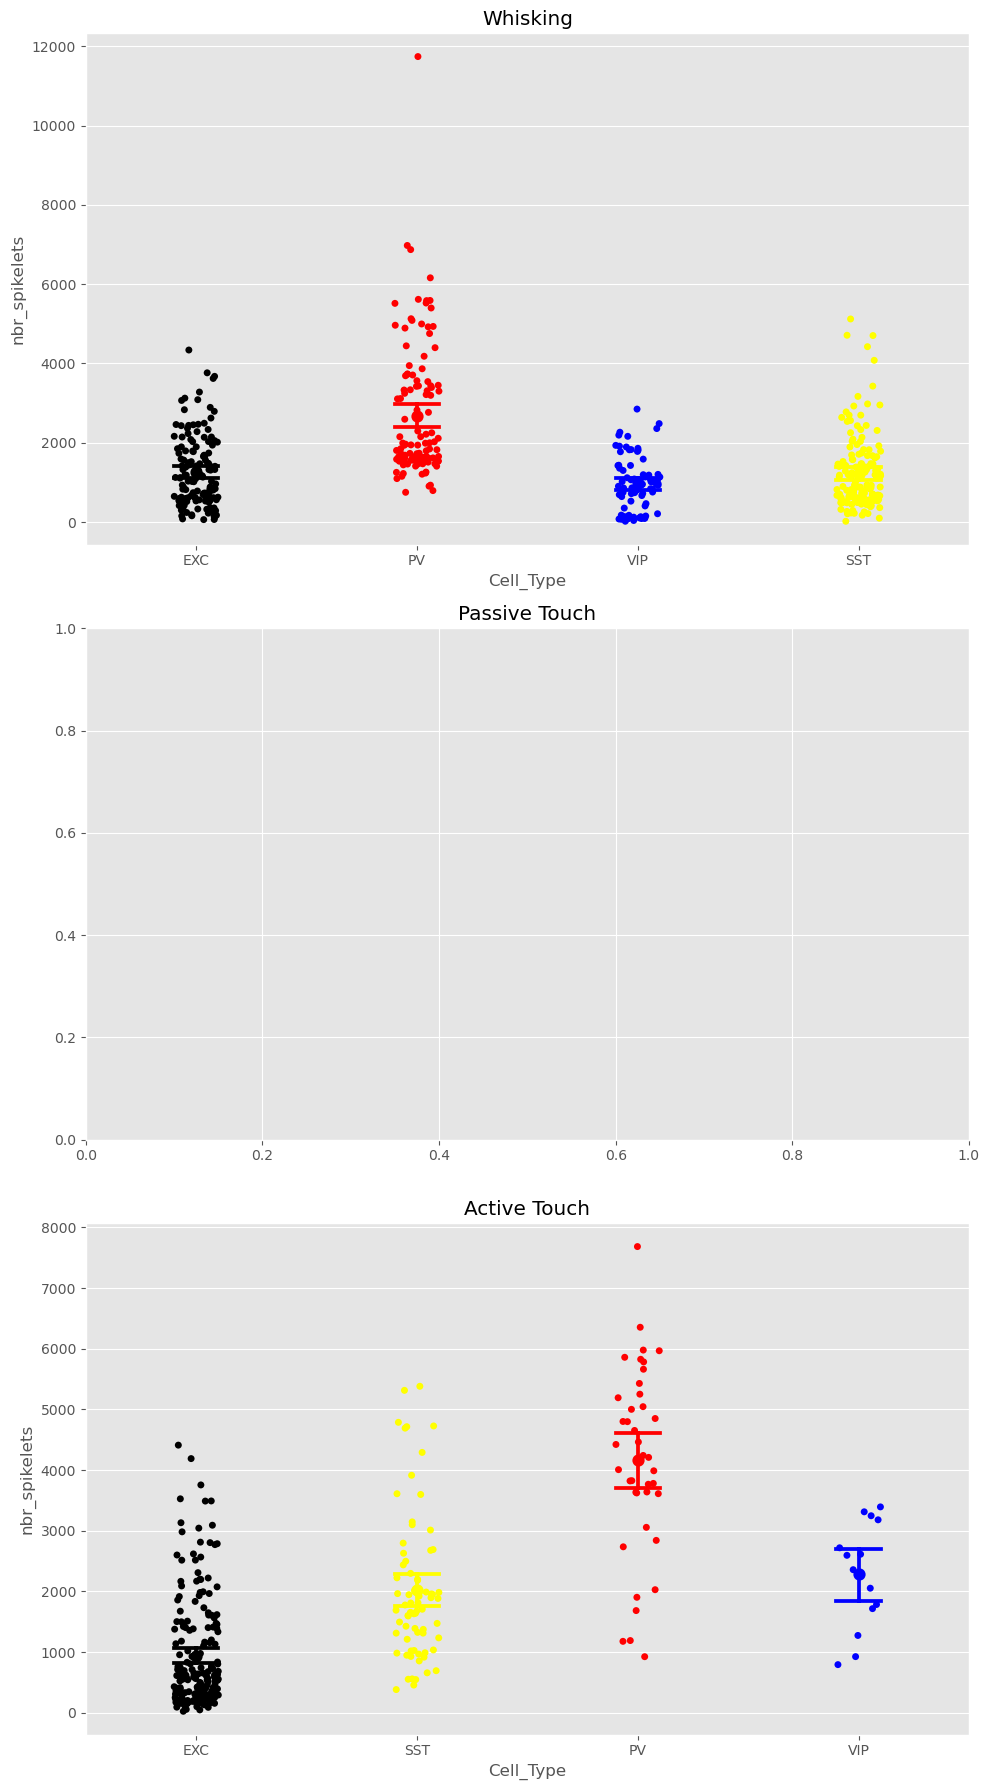

In [39]:
palette = {'EXC': 'black', 'PV': 'red', 'VIP': 'blue', 'SST': 'yellow'}

# Create the subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Create the plots
for ax, df, title in zip(axes, [whisking_df, passive_touch_df, active_touch_df], ['Whisking', 'Passive Touch', 'Active Touch']):
    sns.stripplot(x=x, y=y, data=df, color=".25", jitter=True, ax=ax, palette=palette)
    sns.pointplot(x=x, y=y, data=df, capsize=.2, ax=ax, palette=palette)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [45]:
# stats comparison between cell types (Tukey's HSD test)
from scipy.stats import tukey_hsd

result_df = merged_df

Obs_EXC = result_df[result_df.Cell_Type=='EXC']['nbr_spikelets'].values
Obs_PV = result_df[result_df.Cell_Type=='PV']['nbr_spikelets'].values
Obs_VIP = result_df[result_df.Cell_Type=='VIP']['nbr_spikelets'].values
Obs_SST = result_df[result_df.Cell_Type=='SST']['nbr_spikelets'].values
    
Res=tukey_hsd(Obs_EXC, Obs_PV, Obs_VIP, Obs_SST)
print(Res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)  -1982.862     0.000 -2268.493 -1697.231
 (0 - 2)   -109.351     0.856  -463.211   244.508
 (0 - 3)   -413.629     0.000  -670.393  -156.866
 (1 - 0)   1982.862     0.000  1697.231  2268.493
 (1 - 2)   1873.511     0.000  1479.208  2267.813
 (1 - 3)   1569.233     0.000  1259.095  1879.370
 (2 - 0)    109.351     0.856  -244.508   463.211
 (2 - 1)  -1873.511     0.000 -2267.813 -1479.208
 (2 - 3)   -304.278     0.156  -678.198    69.642
 (3 - 0)    413.629     0.000   156.866   670.393
 (3 - 1)  -1569.233     0.000 -1879.370 -1259.095
 (3 - 2)    304.278     0.156   -69.642   678.198



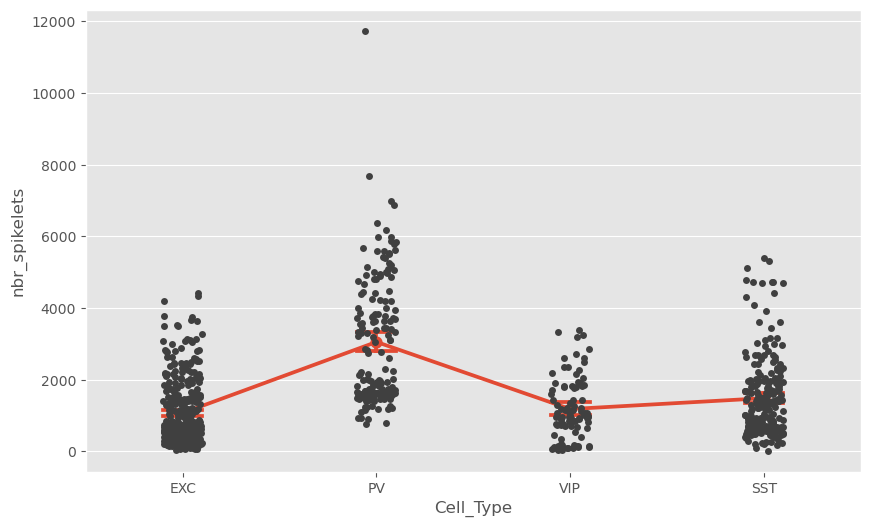

In [36]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(merged_df.Cell_Type.unique()):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['std_vm'].values * 1000 #in mV
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.nanmean(obs_values),
                 yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5, 
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('SD of Vm (mV)')
ax.set_title('SD of Vm - free whisking')
    
    
# Save figure
fname = os.path.join(figure_path, '5_Mean_Vm_SD.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
       
